# Myers–Briggs Type Indicator (MBTI) Personality Prediction

## Libraries and Global Settings

In [1]:
import re
import os
import spacy
import pickle
import warnings
import numpy as np
import pandas as pd

from ipywidgets import widgets, interact
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
if not os.path.isfile("mbti_normalized.csv"):
    df = pd.read_csv('mbti_1.csv', encoding='utf8')
else:
    df = pd.read_csv('mbti_normalized.csv', encoding='utf8')

In [3]:
df.head(10)

,Unnamed: 0,type,posts,normalized_text
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank life change exp...
1,1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post alarming sex boring position ex...
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Dear enjoy conversation day Esoteric gabbe nat...
4,4,ENTJ,'You're fired.|||That's another silly misconce...,fire silly misconception approach logically ke...
5,5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,Science perfect scientist claim scientific inf...
6,6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",draw nail haha professional nail yes gel mean ...
7,7,INTJ,'I tend to build up a collection of things on ...,tend build collection thing desktop use freque...
8,8,INFJ,"I'm not sure, that's a good question. The dist...",sure good question distinction dependant perce...
9,9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,position actually let person reason unfortunat...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8675 non-null   int64 
 1   type             8675 non-null   object
 2   posts            8675 non-null   object
 3   normalized_text  8674 non-null   object
dtypes: int64(1), object(3)
memory usage: 271.2+ KB


## Data Visualization

## Preprocessing

### Text Normalization

In [5]:
def normalizer(sentence):
 
    # Remove ||| from kaggle dataset
    sentence = re.sub("[]|||[]", " ", sentence)

    # remove reddit subreddit urls
    sentence = re.sub("/r/[0-9A-Za-z]", "", sentence)

    # remove MBTI types
    MBTI_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
              'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ',
              'MBTI']
    MBTI_types = [ti.lower() for ti in MBTI_types] + [ti.lower() + 's' for ti in MBTI_types]

    tokens = nlp(sentence)

    tokens = [ti for ti in tokens if ti.lower_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if not ti.is_space]
    tokens = [ti for ti in tokens if not ti.is_punct]
    tokens = [ti for ti in tokens if not ti.like_num]
    tokens = [ti for ti in tokens if not ti.like_url]
    tokens = [ti for ti in tokens if not ti.like_email]
    tokens = [ti for ti in tokens if ti.lower_ not in MBTI_types]


    # lemmatize
    tokens = [ti.lemma_ for ti in tokens if ti.lemma_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if len(ti) > 1]
    
    text = " ".join(tokens)
    return text

In [6]:
if not os.path.isfile("mbti_normalized.csv"):
    df['normalized_text'] = df.posts.apply(normalizer)
    df.to_csv('mbti_normalized.csv')

In [7]:
df.head(5)

,Unnamed: 0,type,posts,normalized_text
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter play prank life change exp...
1,1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post alarming sex boring position ex...
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing curse absolutely pos...
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Dear enjoy conversation day Esoteric gabbe nat...
4,4,ENTJ,'You're fired.|||That's another silly misconce...,fire silly misconception approach logically ke...


In [8]:
# Drop unnamed columns
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[1], axis=1)
df

,type,normalized_text
0,INFJ,moment sportscenter play prank life change exp...
1,ENTP,find lack post alarming sex boring position ex...
2,INTP,good course know blessing curse absolutely pos...
3,INTJ,Dear enjoy conversation day Esoteric gabbe nat...
4,ENTJ,fire silly misconception approach logically ke...
...,...,...
8670,ISFP,ixfp think cat Fi dom reason especially websit...
8671,ENFP,thread exist someplace heck delete Ooops guess...
8672,INTP,question thing purple pill pick win lottery nu...
8673,INFP,conflicted right come want child honestly mate...


### Vectorization

In [9]:
train, test = train_test_split(df, test_size=.2)

In [10]:
train

,type,normalized_text
7184,ENTP,gay talk girl guy experience conclude woman co...
7418,INFP,vague underlie sense anxiety change happen lif...
3863,INTP,like chess play week leave month play week lea...
6985,INFJ,like know old want think wink true huge fight ...
844,INTP,form synesthesia ordinal linguistic personifia...
...,...,...
5288,ESTP,description Se aware physical environment head...
1640,ENFJ,max Caitlyn Hmmm judge new episode Wind Rider ...
6420,INTJ,thread motivate finally research thing stock r...
6403,INTJ,psychologist tell suffer unrelenting standard ...


In [11]:
X_train = train['normalized_text']
y_train = train['type']
X_test = test['normalized_text']
y_test = test['type']

In [12]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train.values.astype('U'))
X_train_tf = tf_idf.transform(X_train.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 6940, n_features: 80876


In [13]:
X_test_tf = tf_idf.transform(X_test.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 1735, n_features: 80876


In [14]:
X_train = X_train_tf
X_test = X_test_tf

In [15]:
X_test.shape

(1735, 80876)

## Machine Learning

In [16]:
if not os.path.isfile("model_lr.pickle"):
    # parameter grid
    parameters_lr = {
        'penalty' : ['l1', 'l2'], 
        'C'       : np.logspace(-4, 4, 20),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter' : [50, 100, 1000, 2500, 5000]
    }

In [17]:
if not os.path.isfile("model_lr.pickle"):
    model_LR = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
    model_LR = model_LR.fit(X_train, y_train)
    print("\n model_LR: best estimator across ALL searched params:\n",model_LR.best_estimator_)
    print("\n model_LR: best parameters across ALL searched params:\n",model_LR.best_params_)

**After applying GridSearchCV for the Logistic Regression model,**

* The best estimator across ALL searched params = 
            LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
                   
* The best parameters across ALL searched params = 
            {'C': 78.47599703514607, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}

In [18]:
model_LR = LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
model_LR = model_LR.fit(X_train, y_train)

In [19]:
output_LR = model_LR.predict(X_test)

In [20]:
if not os.path.isfile("model_lr.pickle"):
    # Pickle the model
    with open('model_lr.pickle', 'wb') as files:
        pickle.dump(model_LR, files)

## Evaluation

In [21]:
# Calculating the accuracy of the KNN model
accuracy = accuracy_score(y_test, output_LR)
accuracy

0.43054755043227666

In [22]:
# Calculating the f1_score of the KNN model
f1_score = f1_score(y_test, output_LR, average='macro')
f1_score

0.23937585281231752

In [23]:
# Calculating the recall of the KNN model
recall = recall_score(y_test, output_LR, average='macro')
recall

0.22241197092926893

In [24]:
# Calculating the precision_score of the KNN model
precision_score = precision_score(y_test, output_LR, average='macro')
precision_score

0.39813606807025803

In [25]:
#classification report
classification_report = classification_report(y_test, output_LR)
print(classification_report)

              precision    recall  f1-score   support

        ENFJ       1.00      0.07      0.12        45
        ENFP       0.41      0.31      0.35       127
        ENTJ       0.64      0.20      0.30        46
        ENTP       0.41      0.28      0.33       146
        ESFJ       0.00      0.00      0.00        10
        ESFP       0.00      0.00      0.00         9
        ESTJ       0.00      0.00      0.00         6
        ESTP       0.00      0.00      0.00        22
        INFJ       0.42      0.49      0.46       298
        INFP       0.46      0.64      0.53       380
        INTJ       0.37      0.47      0.41       204
        INTP       0.43      0.55      0.48       258
        ISFJ       0.75      0.08      0.14        39
        ISFP       0.31      0.08      0.13        48
        ISTJ       0.57      0.10      0.17        40
        ISTP       0.61      0.30      0.40        57

    accuracy                           0.43      1735
   macro avg       0.40   

In [26]:
#confusion matrix
print("confusion matrix")
confusion_matrix = confusion_matrix(y_test,output_LR)
print(confusion_matrix)

confusion matrix
[[  3   4   0   0   0   0   0   0  23   9   5   1   0   0   0   0]
 [  0  39   0   7   0   0   0   0  25  41   7   7   0   0   0   1]
 [  0   2   9   6   0   0   0   0   5   4  13   7   0   0   0   0]
 [  0   5   0  41   0   0   0   0  12  21  18  45   1   0   0   3]
 [  0   1   0   2   0   0   0   0   3   2   1   1   0   0   0   0]
 [  0   2   0   0   0   0   0   0   2   1   3   1   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   2   1   2   0   0   0   0]
 [  0   3   1   1   0   0   0   0   3   4   3   4   0   1   1   1]
 [  0   5   1   7   0   0   0   0 147  96  24  14   0   3   0   1]
 [  0  18   0  12   0   0   0   0  54 243  17  33   0   2   0   1]
 [  0   3   1   5   0   0   0   0  21  25  96  47   0   1   2   3]
 [  0   4   0  14   0   0   0   0  22  35  40 141   0   1   0   1]
 [  0   4   1   0   0   0   0   0  14  10   5   2   3   0   0   0]
 [  0   3   0   1   0   0   0   0  10  20   3   7   0   4   0   0]
 [  0   0   0   1   0   0   0   0   2  10  16

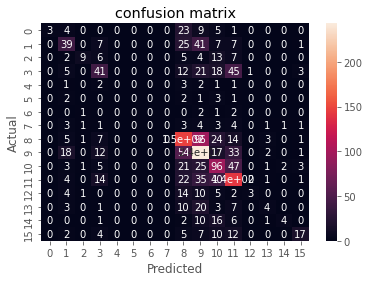

In [27]:
sns.heatmap(confusion_matrix,annot=True,cbar_kws={"orientation":"vertical"})

## Display the visualization of the Confusion Matrix.
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("confusion matrix")
plt.show()

In [28]:
print("Normalized confusion matrix")
confusion_matrix_Normalized = np.round(confusion_matrix/np.sum(confusion_matrix,axis=1).reshape(-1,1),2)
print(confusion_matrix_Normalized)

Normalized confusion matrix
[[0.07 0.09 0.   0.   0.   0.   0.   0.   0.51 0.2  0.11 0.02 0.   0.
  0.   0.  ]
 [0.   0.31 0.   0.06 0.   0.   0.   0.   0.2  0.32 0.06 0.06 0.   0.
  0.   0.01]
 [0.   0.04 0.2  0.13 0.   0.   0.   0.   0.11 0.09 0.28 0.15 0.   0.
  0.   0.  ]
 [0.   0.03 0.   0.28 0.   0.   0.   0.   0.08 0.14 0.12 0.31 0.01 0.
  0.   0.02]
 [0.   0.1  0.   0.2  0.   0.   0.   0.   0.3  0.2  0.1  0.1  0.   0.
  0.   0.  ]
 [0.   0.22 0.   0.   0.   0.   0.   0.   0.22 0.11 0.33 0.11 0.   0.
  0.   0.  ]
 [0.   0.   0.17 0.   0.   0.   0.   0.   0.   0.33 0.17 0.33 0.   0.
  0.   0.  ]
 [0.   0.14 0.05 0.05 0.   0.   0.   0.   0.14 0.18 0.14 0.18 0.   0.05
  0.05 0.05]
 [0.   0.02 0.   0.02 0.   0.   0.   0.   0.49 0.32 0.08 0.05 0.   0.01
  0.   0.  ]
 [0.   0.05 0.   0.03 0.   0.   0.   0.   0.14 0.64 0.04 0.09 0.   0.01
  0.   0.  ]
 [0.   0.01 0.   0.02 0.   0.   0.   0.   0.1  0.12 0.47 0.23 0.   0.
  0.01 0.01]
 [0.   0.02 0.   0.05 0.   0.   0.   0.   0.09 0.14 0

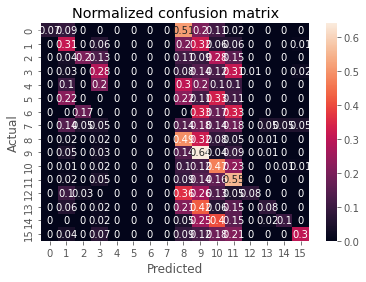

In [29]:
sns.heatmap(confusion_matrix_Normalized,annot=True,cbar_kws={"orientation":"vertical"})

# Display the visualization of the Normalized Confusion Matrix.
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized confusion matrix")
plt.show()

## Example: how to use a pickled model for predictions

```
with open('model_lr.pickle', 'rb') as f:
    pickled_model_lr = pickle.load(f)

text = 'When I was just a little girl, I keep to myself, I hardly talk to people, even when I’m in school I don’t talk to my friends in class. Most times when my teacher ask me a question, she forces words out of my mouth. My mum told me all this.'

normalized_text = normalizer(text)
vectorized_text = tf_idf.transform([normalized_text])
prediction = pickled_model_lr.predict(vectorized_text)

prediction
```

## Reference
M. J, (MBTI) Myers-Briggs Personality Type Dataset, 2017, Kaggle, May 2022. [Online]. Available: https://www.kaggle.com/datasnaek/mbti-type.